In [1]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install gdown==4.6.0
!gdown "1KOmSrlGcC50PjkvRVbyb_WoWHVql06J-&confirm=t"

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-lphkmw95
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-lphkmw95
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit f757e72b02fefe20e710b3be50b8c4ebe585db7b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl size=1098115 sha256=47b79203d43a84cdcc88d309710e6c0fb69fc215c57d79b382bc4ac2f1ef820c
  Stored in directory: /tmp/pip-ephem-wheel-cache-75cm2tk4/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch_geometric
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?i

In [2]:
import os
os.mkdir("/content/data/")
os.mkdir("/content/data/UPFD/")
os.mkdir("/content/data/UPFD/politifact/")
os.mkdir("/content/data/UPFD/politifact/raw")
!unzip politifact.zip -d "/content/data/UPFD/politifact/raw"

Archive:  politifact.zip
  inflating: /content/data/UPFD/politifact/raw/A.txt  
  inflating: /content/data/UPFD/politifact/raw/graph_labels.npy  
  inflating: /content/data/UPFD/politifact/raw/new_bert_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/new_content_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/new_profile_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/new_spacy_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/node_graph_id.npy  
  inflating: /content/data/UPFD/politifact/raw/test_idx.npy  
  inflating: /content/data/UPFD/politifact/raw/train_idx.npy  
  inflating: /content/data/UPFD/politifact/raw/val_idx.npy  


In [3]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected

In [132]:
argdataset = 'politifact' #politifact, gossipcop
argfeature = 'content' #spacy, bert, content, profile

path = '/content/data/UPFD'
train_dataset = UPFD(path, argdataset, argfeature, 'train', ToUndirected())
val_dataset = UPFD(path, argdataset, argfeature, 'val', ToUndirected())
test_dataset = UPFD(path, argdataset, argfeature, 'test', ToUndirected())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [133]:
import numpy as np
train_x = []
train_y = []
test_x = []
test_y = []
for item in train_dataset:
    train_x.append(item.x[0].numpy())
    train_y.append(item.y[0].item())
for item in test_dataset:
    test_x.append(item.x[0].numpy())
    test_y.append(item.y[0].item())



In [134]:
from sklearn.neighbors import KNeighborsClassifier
knns = [KNeighborsClassifier(i) for i in range(1,11)]

for knn in knns:
    knn.fit(train_x,train_y)
    print(knn.score(test_x,test_y))


0.6968325791855203
0.6244343891402715
0.6787330316742082
0.6515837104072398
0.7058823529411765
0.6742081447963801
0.7285067873303167
0.7013574660633484
0.755656108597285
0.7149321266968326


# Vis

In [119]:
import networkx as nx
G = nx.Graph()
for root_id in range(len(train_dataset)):
    G.add_node(root_id, x=train_dataset[root_id].x[0], y=train_dataset[root_id].y[0])

In [120]:
import torch.nn.functional as F
import torch
for root_id in range(len(train_dataset)-1):
    for second_id in range(root_id+1,len(train_dataset)):
      #css = F.cosine_similarity(train_dataset[root_id].x[0],train_dataset[second_id].x[0],dim = 0)
      dist = (train_dataset[root_id].x[0] - train_dataset[second_id].x[0]).pow(2).sum(0).sqrt()
      if dist < 0.05:
        G.add_edge(root_id, second_id, weight=1)

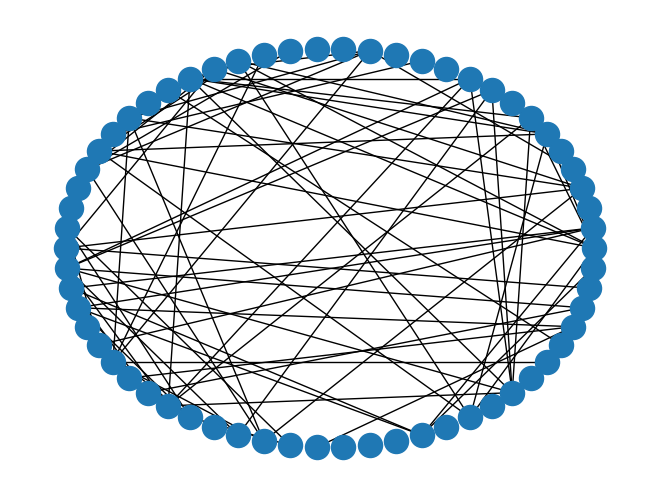

In [122]:
nx.draw(G,pos=nx.shell_layout(G),label=True)